## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime
import wandb

In [2]:
sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

import segmentation_models_pytorch as smp

In [3]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [4]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 8

    batch_size = 16 # 32
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2

    objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


In [5]:
IS_DEBUG = False
mode = 'train' if IS_DEBUG else 'test'
TH = 0.4

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## helper

In [7]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## dataset

In [8]:
def read_image(fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

In [9]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image


In [10]:
def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id)
    
    x1_list = list(range(0, test_images.shape[1]-CFG.tile_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.tile_size+1, CFG.stride))
    
    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.tile_size
            x2 = x1 + CFG.tile_size
            
            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
            
    test_dataset = CustomDataset(test_images_list, CFG, transform=get_transforms(data='valid', cfg=CFG))
    
    test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    return test_loader, xyxys

## model

In [11]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        output = output.squeeze(-1)
        return output

def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)
    return model


In [12]:
class EnsembleModel:
    def __init__(self, use_tta=False):
        self.models = []
        self.use_tta = use_tta

    def __call__(self, x):
        outputs = [torch.sigmoid(model(x)).to('cpu').numpy()
                   for model in self.models]
        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)

def build_ensemble_model():
    model = EnsembleModel()
    for fold in [1, 2, 3]:
        _model = build_model(CFG, weight=None)
        _model.to(device)

        model_path = f'/kaggle/input/vesuvius-models-public/{CFG.exp_name}/vesuvius-models/Unet_fold{fold}_best.pth'
        state = torch.load(model_path)['model']
        _model.load_state_dict(state)
        _model.eval()
        
        model.add_model(_model)
    
    return model

In [13]:
if mode == 'test':
    fragment_ids = sorted(os.listdir(CFG.comp_dataset_path + mode))
else:
    fragment_ids = [3]

In [14]:
model = build_ensemble_model()

model_name Unet
backbone se_resnext50_32x4d
model_name Unet
backbone se_resnext50_32x4d
model_name Unet
backbone se_resnext50_32x4d


## main

  0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/1365 [00:00<?, ?it/s]

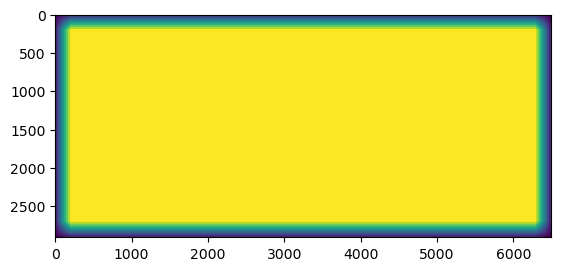

mask_count_min: 1.0


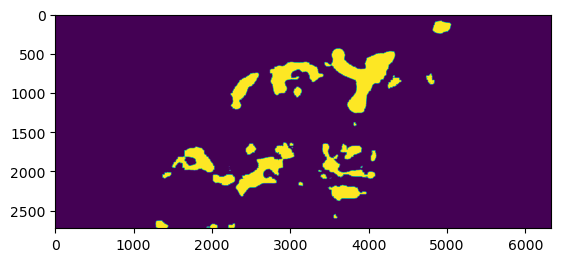

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2715 [00:00<?, ?it/s]

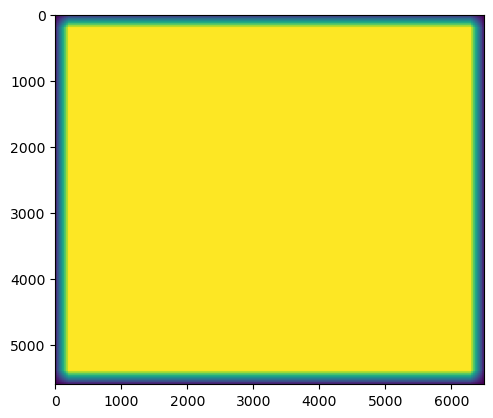

mask_count_min: 1.0


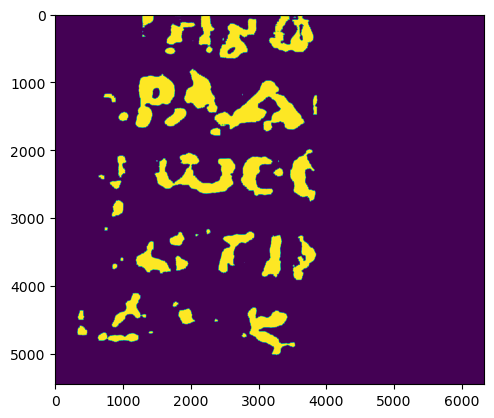

In [15]:
results = []
for fragment_id in fragment_ids:
    
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.tile_size - binary_mask.shape[0] % CFG.tile_size)
    pad1 = (CFG.tile_size - binary_mask.shape[1] % CFG.tile_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = np.zeros(binary_mask.shape)
    mask_count = np.zeros(binary_mask.shape)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        batch_size = images.size(0)

        with torch.no_grad():
            y_preds = model(images)

        start_idx = step*CFG.batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))
    
    plt.imshow(mask_count)
    plt.show()
    
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    mask_pred = (mask_pred >= TH).astype(int)
    mask_pred *= binary_mask
    
    plt.imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    results.append((fragment_id, inklabels_rle))
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()


## submission

In [16]:
sub = pd.DataFrame(results, columns=['Id', 'Predicted'])

In [17]:
sub

,Id,Predicted
0,a,549308 2 549311 1 555630 18 561951 29 568275 3...
1,b,1316 136 2248 5 7623 169 8164 24 8543 52 8613 ...


In [18]:
sample_sub = pd.read_csv(CFG.comp_dataset_path + 'sample_submission.csv')
sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')

In [19]:
sample_sub

,Id,Predicted
0,a,549308 2 549311 1 555630 18 561951 29 568275 3...
1,b,1316 136 2248 5 7623 169 8164 24 8543 52 8613 ...


In [20]:
sample_sub.to_csv("submission.csv", index=False)